# Cleaning and EDA

---

## Imports and Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import metrics

from sklearn.model_selection import GridSearchCV

In [60]:
def qual_to_num(data, feature):
    qual_conversion = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0, np.nan: 0}
    
    data[feature] = data[feature].apply(lambda x: qual_conversion[x])
    
    return data
    
    
def vif_df(df):
    corr_features = df.columns
    vif_values = [variance_inflation_factor(df.values, i) for i in range(len(corr_features))]
    
    vif = pd.DataFrame(vif_values,
                   index = corr_features,
                   columns = ['vif']).sort_values(by = 'vif', ascending = False)
    
    return vif

In [3]:
def setup_test():
    test_data = pd.read_csv('../datasets/test.csv')
    test_features = ['MS Zoning', 'Lot Area', 'Land Contour', 'Land Slope', 'Neighborhood', 'Condition 1',
            'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
           'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
           'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Kitchen Qual', 'Bedroom AbvGr',
           'Full Bath', 'Half Bath', 'Fireplaces', 'Fireplace Qu', 'BsmtFin SF 1', 'Bsmt Unf SF', '1st Flr SF', '2nd Flr SF']
    
    
    test_data = test_data[test_features]
    test_data.columns = [col.lower().replace(' ','_').replace('/','_') for col in test_data.columns]
    
    
    # converts descriptive rating to numerical
    test_data = qual_to_num(test_data, 'bsmt_qual')
    test_data = qual_to_num(test_data, 'bsmt_cond')
    test_data = qual_to_num(test_data, 'kitchen_qual')
    test_data = qual_to_num(test_data, 'exter_qual')
    test_data = qual_to_num(test_data, 'exter_cond')
    test_data = qual_to_num(test_data, 'fireplace_qu')
    
    # combines basment quality and condition ratings via multiplication
    test_data['bsmt_qual_cond'] = test_data['bsmt_qual'] * test_data['bsmt_cond']
    test_data.drop(columns = ['bsmt_qual', 'bsmt_cond'], inplace = True)
    
    # combines overall quality and condition into one column via multiplication
    test_data['qual_cond'] = test_data['overall_qual'] * test_data['overall_cond']
    test_data.drop(columns = ['overall_qual', 'overall_cond'], inplace = True)

    # combines exterior quality and condition into one column via multiplication
    test_data['exter_qual_cond'] = test_data['exter_qual'] * test_data['exter_cond']
    test_data.drop(columns = ['exter_qual', 'exter_cond'], inplace = True)

    # combines fireplace count and quality rating via multiplication
    test_data['fireplaces_weighted'] = test_data['fireplaces'] * test_data['fireplace_qu']
    test_data.drop(columns = ['fireplaces', 'fireplace_qu'], inplace = True)
    
    # adds square feet (SF) measurements with weights:
    # 1*(Finished SF) + 0.5(Unfinished SF)
    test_data['bsmt_weighted_sf'] = test_data['bsmtfin_sf_1'] + 0.5*test_data['bsmt_unf_sf']
    test_data.drop(columns = ['bsmtfin_sf_1', 'bsmt_unf_sf'], inplace = True)
    
    # combines full bath and half bath into one column
    test_data['bath'] = test_data['full_bath'] + 0.5*test_data['half_bath']
    test_data.drop(columns = ['full_bath', 'half_bath'], inplace = True)
    
    #combines 1st floor and 2nd floor square feet areas
    test_data['sq_ft'] = test_data['1st_flr_sf'] + test_data['2nd_flr_sf']
    test_data.drop(columns = ['1st_flr_sf', '2nd_flr_sf'], inplace = True)
    
    return test_data
    
    

def dummify_train_test(train, numeric_cols, categ_cols):
    
    test = setup_test()
    features = numeric_cols + categ_cols
    
    train_with_dummies = pd.get_dummies(train[features], columns = categ_cols, drop_first = True)
    test_with_dummies = pd.get_dummies(test[features], columns = categ_cols, drop_first = True)
    
    # save dummy column names from both train and test to a set
    both_columns_set = set(train_with_dummies.columns).union(set(test_with_dummies.columns))

    # for any column names not in set add column with 0s
    for col in both_columns_set:
        if col not in train_with_dummies.columns:
            train_with_dummies[col] = 0
        if col not in test_with_dummies.columns:
            test_with_dummies[col] = 0
            
    column_order = train_with_dummies.columns
    test_with_dummies = test_with_dummies[column_order]
    
    return train_with_dummies, test_with_dummies

In [4]:
def submit(test, kag_preds, attempt_num):
    kag_sub = {'Id': test['Id'], 'SalePrice': kag_preds}
    kag_sub = pd.DataFrame(kag_sub)
    
    file_path = '../datasets/submission' + str(attempt_num) + '_john.csv'
    kag_sub.to_csv(file_path, index = False)

---

## Dealing with Missing Values

In [5]:
raw_housing = pd.read_csv('../datasets/train.csv')

In [6]:
raw_housing.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [7]:
init_features = ['MS Zoning', 'Lot Area', 'Land Contour', 'Land Slope', 'Neighborhood', 'Condition 1',
            'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
           'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
           'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Kitchen Qual', 'Bedroom AbvGr',
           'Full Bath', 'Half Bath', 'Fireplaces', 'Fireplace Qu', 'BsmtFin SF 1', 'Bsmt Unf SF', '1st Flr SF', '2nd Flr SF', 'Sale Type', 'SalePrice']

In [8]:
house = raw_housing[init_features].copy()
house.head()

,MS Zoning,Lot Area,Land Contour,Land Slope,Neighborhood,Condition 1,Bldg Type,House Style,Overall Qual,Overall Cond,...,Full Bath,Half Bath,Fireplaces,Fireplace Qu,BsmtFin SF 1,Bsmt Unf SF,1st Flr SF,2nd Flr SF,Sale Type,SalePrice
0,RL,13517,Lvl,Gtl,Sawyer,RRAe,1Fam,2Story,6,8,...,2,1,0,NaN,533.0,192.0,725,754,WD,130500
1,RL,11492,Lvl,Gtl,SawyerW,Norm,1Fam,2Story,7,5,...,2,1,1,TA,637.0,276.0,913,1209,WD,220000
2,RL,7922,Lvl,Gtl,NAmes,Norm,1Fam,1Story,5,7,...,1,0,0,NaN,731.0,326.0,1057,0,WD,109000
3,RL,9802,Lvl,Gtl,Timber,Norm,1Fam,2Story,5,5,...,2,1,0,NaN,0.0,384.0,744,700,WD,174000
4,RL,14235,Lvl,Gtl,SawyerW,Norm,1Fam,1.5Fin,6,8,...,2,0,0,NaN,0.0,676.0,831,614,WD,138500


In [9]:
house.columns = [col.lower().replace(' ','_').replace('/','_') for col in house.columns]

In [10]:
house.head()

,ms_zoning,lot_area,land_contour,land_slope,neighborhood,condition_1,bldg_type,house_style,overall_qual,overall_cond,...,full_bath,half_bath,fireplaces,fireplace_qu,bsmtfin_sf_1,bsmt_unf_sf,1st_flr_sf,2nd_flr_sf,sale_type,saleprice
0,RL,13517,Lvl,Gtl,Sawyer,RRAe,1Fam,2Story,6,8,...,2,1,0,NaN,533.0,192.0,725,754,WD,130500
1,RL,11492,Lvl,Gtl,SawyerW,Norm,1Fam,2Story,7,5,...,2,1,1,TA,637.0,276.0,913,1209,WD,220000
2,RL,7922,Lvl,Gtl,NAmes,Norm,1Fam,1Story,5,7,...,1,0,0,NaN,731.0,326.0,1057,0,WD,109000
3,RL,9802,Lvl,Gtl,Timber,Norm,1Fam,2Story,5,5,...,2,1,0,NaN,0.0,384.0,744,700,WD,174000
4,RL,14235,Lvl,Gtl,SawyerW,Norm,1Fam,1.5Fin,6,8,...,2,0,0,NaN,0.0,676.0,831,614,WD,138500


In [11]:
house.isnull().sum()

ms_zoning            0
lot_area             0
land_contour         0
land_slope           0
neighborhood         0
condition_1          0
bldg_type            0
house_style          0
overall_qual         0
overall_cond         0
year_built           0
year_remod_add       0
mas_vnr_type        22
exter_qual           0
exter_cond           0
bsmt_qual           55
bsmt_cond           55
garage_area          1
wood_deck_sf         0
open_porch_sf        0
kitchen_qual         0
bedroom_abvgr        0
full_bath            0
half_bath            0
fireplaces           0
fireplace_qu      1000
bsmtfin_sf_1         1
bsmt_unf_sf          1
1st_flr_sf           0
2nd_flr_sf           0
sale_type            0
saleprice            0
dtype: int64

Below we see that **there is one row missing all the basement data**. It may be **fair to assume that the home is missing a basement and these values would all be zero**.

In [12]:
null_basement_info = house[house['bsmtfin_sf_1'].isna()]
null_basement_info[['bsmt_qual', 'bsmt_cond', 'garage_area', 'bsmtfin_sf_1', 'bsmt_unf_sf']]

,bsmt_qual,bsmt_cond,garage_area,bsmtfin_sf_1,bsmt_unf_sf
1327,NaN,NaN,280.0,NaN,NaN


In [13]:
# turn missing basement square feet info into zeros
# basement quality and condition will be dealt with later
house.loc[house['bsmtfin_sf_1'].isna(), ['bsmtfin_sf_1', 'bsmt_unf_sf']] = 0

We only have one garage related column so it is more challenging to infer about the row with a missing `garage_area` value. It is likely fine to convert this singe row's `garage_area` value to zero also.

In [14]:
house.loc[house['garage_area'].isna(), 'garage_area'] = 0

Missing values in the basement columns appear to be homes without basements. We see the missing 55 entries in the same rows for `bsmt_qual` and `bsmt_cond`.

In [15]:
# takes the data that is missing bsmt_qual and checks what the bsmt_cond are
house.loc[house['bsmt_qual'].isnull(), 'bsmt_cond'].value_counts(dropna = False)

NaN    55
Name: bsmt_cond, dtype: int64

In [16]:
# converts descriptive rating to numerical
house = qual_to_num(house, 'bsmt_qual')
house = qual_to_num(house, 'bsmt_cond')

We see the same issue arise with `fireplaces` and `fireplace_qu`. The homes with zero fireplaces are fittingly missing descriptions for the quality of their fireplace.

In [17]:
# homes with 0 fireplaces are have NaN fireplace_qu values
house.loc[house['fireplaces'] == 0, 'fireplace_qu'].value_counts(dropna = False)

NaN    1000
Name: fireplace_qu, dtype: int64

In [18]:
# converts descriptive rating to numerical
house = qual_to_num(house, 'fireplace_qu')

The only remaining column with missing entires is `mas_vnr_typ`. Below we see that 'None' is the most frequent value in the column. With only 22 missing values, it seems like it will not be harmful to replace the missing values with 'None'

In [19]:
house.isnull().sum()

ms_zoning          0
lot_area           0
land_contour       0
land_slope         0
neighborhood       0
condition_1        0
bldg_type          0
house_style        0
overall_qual       0
overall_cond       0
year_built         0
year_remod_add     0
mas_vnr_type      22
exter_qual         0
exter_cond         0
bsmt_qual          0
bsmt_cond          0
garage_area        0
wood_deck_sf       0
open_porch_sf      0
kitchen_qual       0
bedroom_abvgr      0
full_bath          0
half_bath          0
fireplaces         0
fireplace_qu       0
bsmtfin_sf_1       0
bsmt_unf_sf        0
1st_flr_sf         0
2nd_flr_sf         0
sale_type          0
saleprice          0
dtype: int64

In [20]:
house['mas_vnr_type'].value_counts(dropna = False)

None       1218
BrkFace     630
Stone       168
NaN          22
BrkCmn       13
Name: mas_vnr_type, dtype: int64

In [21]:
house.loc[house['mas_vnr_type'].isna(), 'mas_vnr_type'] = 'None'

---

## Feature Engineering

In [22]:
# convert descriptive rating to numerical
house = qual_to_num(house, 'kitchen_qual')

In [23]:
# combines overall quality and condition into one column via multiplication
house['qual_cond'] = house['overall_qual'] * house['overall_cond']
house.drop(columns = ['overall_qual', 'overall_cond'], inplace = True)

In [24]:
# converts descriptive rating to numerical
house = qual_to_num(house,'exter_qual')
house = qual_to_num(house, 'exter_cond')

# combines exterior quality and condition into one column via multiplication
house['exter_qual_cond'] = house['exter_qual'] * house['exter_cond']
house.drop(columns = ['exter_qual', 'exter_cond'], inplace = True)

In [25]:
# combines basment quality and condition ratings via multiplication
house['bsmt_qual_cond'] = house['bsmt_qual'] * house['bsmt_cond']
house.drop(columns = ['bsmt_qual', 'bsmt_cond'], inplace = True)

In [26]:
# combines fireplace count and quality rating via multiplication
house['fireplaces_weighted'] = house['fireplaces'] * house['fireplace_qu']
house.drop(columns = ['fireplaces', 'fireplace_qu'], inplace = True)

In [27]:
house['sq_ft'] = house['1st_flr_sf'] + house['2nd_flr_sf']
house.drop(columns = ['1st_flr_sf', '2nd_flr_sf'], inplace = True)

In [28]:
# adds square feet (SF) measurements with weights:
# 1*(Finished SF) + 0.5(Unfinished SF)
house['bsmt_weighted_sf'] = house['bsmtfin_sf_1'] + 0.5*house['bsmt_unf_sf']
house.drop(columns = ['bsmtfin_sf_1', 'bsmt_unf_sf'], inplace = True)

In [29]:
# combines full bath and half bath into one column
house['bath'] = house['full_bath'] + 0.5*house['half_bath']
house.drop(columns = ['full_bath', 'half_bath'], inplace = True)

---

## Removing Outliers and Exploratory Data Analysis

In [30]:
house.describe()

,lot_area,year_built,year_remod_add,garage_area,wood_deck_sf,open_porch_sf,kitchen_qual,bedroom_abvgr,saleprice,qual_cond,exter_qual_cond,bsmt_qual_cond,fireplaces_weighted,sq_ft,bsmt_weighted_sf,bath
count,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,10065.208191,1971.708922,1984.190151,473.440761,93.833740,47.556802,3.517309,2.843491,181469.701609,33.866407,10.518284,10.549000,2.033642,1493.817162,725.810580,1.762799
std,6742.488909,30.177889,21.036250,216.135102,128.549416,66.747241,0.665577,0.826618,79258.659352,9.255859,2.195124,3.061151,2.283203,497.618666,406.466601,0.637775
min,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,2.000000,0.000000,12789.000000,1.000000,2.000000,0.000000,0.000000,334.000000,0.000000,0.000000
25%,7500.000000,1953.500000,1964.500000,319.000000,0.000000,0.000000,3.000000,2.000000,129825.000000,30.000000,9.000000,9.000000,0.000000,1124.500000,440.250000,1.000000
50%,9430.000000,1974.000000,1993.000000,480.000000,0.000000,27.000000,3.000000,3.000000,162500.000000,35.000000,9.000000,12.000000,1.000000,1440.000000,674.500000,2.000000
75%,11513.500000,2001.000000,2004.000000,576.000000,168.000000,70.000000,4.000000,3.000000,214000.000000,40.000000,12.000000,12.000000,4.000000,1728.000000,916.750000,2.500000
max,159000.000000,2010.000000,2010.000000,1418.000000,1424.000000,547.000000,5.000000,8.000000,611657.000000,90.000000,25.000000,20.000000,12.000000,5642.000000,5877.000000,5.000000


The first thing that stands out in our summary statistics is the massive gap between the maximum `lot_area` and the 75th percentile. A full list of columns with questionable max values are:

- `lot_area`
- `wood_deck_sf`
- `open_porch_sf`
- `sale_price`
- `sq_ft`
- and `bsmt_weighted_sf`

Another interesting statistic is the minimum `year_built` is so much lower than the 25th percentile.

Let us investigate the distributions of these columns and remove any outliers that are very distant from the rest of the data.

#### Lot Area

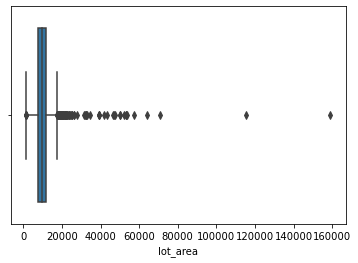

In [31]:
sns.boxplot(x = house['lot_area']);

In [32]:
perc_25 = house['lot_area'].quantile(0.25)
perc_75 = house['lot_area'].quantile(0.75)
large_lot = house[house['lot_area'] > perc_75]

In [33]:
large_lot['lot_area'].value_counts(bins = 25).sort_index()

(11367.514, 17414.4]    424
(17414.4, 23313.8]       55
(23313.8, 29213.2]        9
(29213.2, 35112.6]        6
(35112.6, 41012.0]        3
(41012.0, 46911.4]        3
(46911.4, 52810.8]        5
(52810.8, 58710.2]        4
(58710.2, 64609.6]        1
(64609.6, 70509.0]        0
(70509.0, 76408.4]        1
(76408.4, 82307.8]        0
(82307.8, 88207.2]        0
(88207.2, 94106.6]        0
(94106.6, 100006.0]       0
(100006.0, 105905.4]      0
(105905.4, 111804.8]      0
(111804.8, 117704.2]      1
(117704.2, 123603.6]      0
(123603.6, 129503.0]      0
(129503.0, 135402.4]      0
(135402.4, 141301.8]      0
(141301.8, 147201.2]      0
(147201.2, 153100.6]      0
(153100.6, 159000.0]      1
Name: lot_area, dtype: int64

We see a significant drop off in number of homes containing more than 77,000 square feet of lot area. **Let us trim off these outliers**.

In [34]:
# consider homes with less than 77,000 lot_area
house = house[house['lot_area'] <= 77_000]

#### Wood Deck

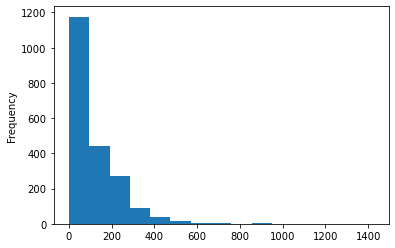

In [35]:
house['wood_deck_sf'].plot.hist(bins = 15);

In [36]:
house['wood_deck_sf'].value_counts(bins = 15).sort_index()

(-1.4249999999999998, 94.933]    1176
(94.933, 189.867]                 441
(189.867, 284.8]                  274
(284.8, 379.733]                   89
(379.733, 474.667]                 39
(474.667, 569.6]                   16
(569.6, 664.533]                    7
(664.533, 759.467]                  4
(759.467, 854.4]                    0
(854.4, 949.333]                    2
(949.333, 1044.267]                 0
(1044.267, 1139.2]                  0
(1139.2, 1234.133]                  0
(1234.133, 1329.067]                0
(1329.067, 1424.0]                  1
Name: wood_deck_sf, dtype: int64

There is three homes with wood decks significantly larger than the rest. Let us drop them.

In [37]:
house = house[house['wood_deck_sf'] < 760]

#### Open Porch

In [38]:
house['open_porch_sf'].value_counts(bins = 15).sort_index()

(-0.548, 36.467]      1178
(36.467, 72.933]       378
(72.933, 109.4]        197
(109.4, 145.867]       122
(145.867, 182.333]      69
(182.333, 218.8]        42
(218.8, 255.267]        27
(255.267, 291.733]      13
(291.733, 328.2]         9
(328.2, 364.667]         2
(364.667, 401.133]       3
(401.133, 437.6]         1
(437.6, 474.067]         1
(474.067, 510.533]       2
(510.533, 547.0]         2
Name: open_porch_sf, dtype: int64

Although there are a few homes with very large open porches, they do not appear to stand out too far from the rest of the data.

#### Square Feet

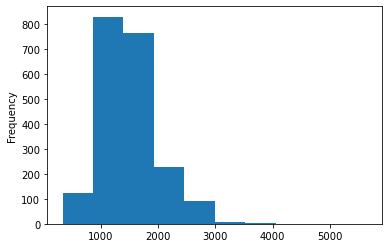

In [39]:
house['sq_ft'].plot.hist();

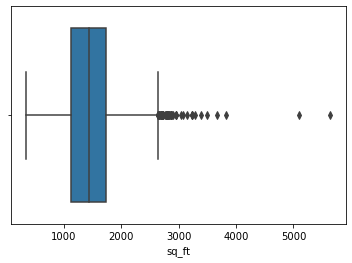

In [40]:
sns.boxplot(x = house['sq_ft']);

In [41]:
house['sq_ft'].value_counts(bins = 20).sort_index()

(328.69100000000003, 599.4]      9
(599.4, 864.8]                 113
(864.8, 1130.2]                401
(1130.2, 1395.6]               428
(1395.6, 1661.0]               475
(1661.0, 1926.4]               288
(1926.4, 2191.8]               146
(2191.8, 2457.2]                81
(2457.2, 2722.6]                66
(2722.6, 2988.0]                26
(2988.0, 3253.4]                 6
(3253.4, 3518.8]                 3
(3518.8, 3784.2]                 1
(3784.2, 4049.6]                 1
(4049.6, 4315.0]                 0
(4315.0, 4580.4]                 0
(4580.4, 4845.8]                 0
(4845.8, 5111.2]                 1
(5111.2, 5376.6]                 0
(5376.6, 5642.0]                 1
Name: sq_ft, dtype: int64

We see two homes with substantially more living space than others. Let us drop these observations.

In [42]:
house = house[house['sq_ft'] < 4050]

#### Sale Price

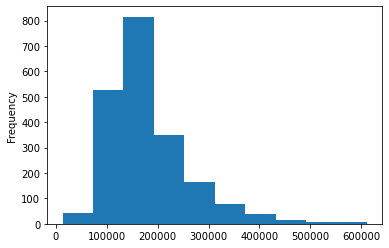

In [46]:
house['saleprice'].plot.hist();

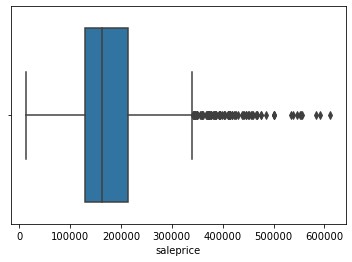

In [47]:
sns.boxplot(x = house['saleprice']);

In [52]:
house['saleprice'].value_counts(bins = 15).sort_index()

(12190.131, 52713.533]       15
(52713.533, 92638.067]      109
(92638.067, 132562.6]       443
(132562.6, 172487.133]      567
(172487.133, 212411.667]    383
(212411.667, 252336.2]      215
(252336.2, 292260.733]      130
(292260.733, 332185.267]     75
(332185.267, 372109.8]       40
(372109.8, 412034.333]       28
(412034.333, 451958.867]     18
(451958.867, 491883.4]        9
(491883.4, 531807.933]        3
(531807.933, 571732.467]      6
(571732.467, 611657.0]        3
Name: saleprice, dtype: int64

Nothing in the above boxplot really suggests we need to remove any data due to their sale price. Let us move on.

#### Weighted Basement Square Feet

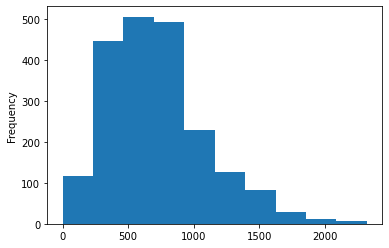

In [54]:
house['bsmt_weighted_sf'].plot.hist();

In [56]:
house['bsmt_weighted_sf'].value_counts(bins = 20)

(347.85, 463.8]      292
(579.75, 695.7]      261
(695.7, 811.65]      260
(463.8, 579.75]      244
(811.65, 927.6]      231
(231.9, 347.85]      154
(927.6, 1043.55]     125
(1043.55, 1159.5]    104
(1159.5, 1275.45]     72
(-2.32, 115.95]       68
(1275.45, 1391.4]     54
(115.95, 231.9]       49
(1391.4, 1507.35]     48
(1507.35, 1623.3]     35
(1623.3, 1739.25]     21
(1739.25, 1855.2]      7
(1855.2, 1971.15]      7
(2203.05, 2319.0]      5
(1971.15, 2087.1]      4
(2087.1, 2203.05]      3
Name: bsmt_weighted_sf, dtype: int64

The weighted basement size column also appears fine as is.

#### Year Built

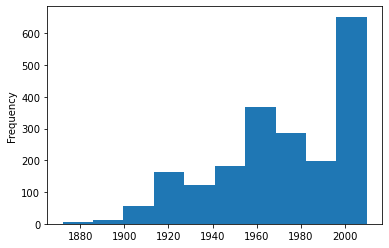

In [57]:
house['year_built'].plot.hist(bins = 10);

In [58]:
house['year_built'].value_counts(bins = 10).sort_index()

(1871.861, 1885.8]      7
(1885.8, 1899.6]       12
(1899.6, 1913.4]       56
(1913.4, 1927.2]      162
(1927.2, 1941.0]      139
(1941.0, 1954.8]      165
(1954.8, 1968.6]      369
(1968.6, 1982.4]      285
(1982.4, 1996.2]      197
(1996.2, 2010.0]      652
Name: year_built, dtype: int64

It does not seem necessary to drop homes built especially long ago. These homes to not appear to have extraordinary sale prices.

In [59]:
house.loc[house['year_built'] < 1900, ['year_built', 'saleprice']].sort_values(by = 'year_built')

,year_built,saleprice
951,1872,122000
136,1875,94000
1134,1879,185000
12,1880,131000
784,1880,117500
1939,1880,295000
394,1885,122500
501,1890,78500
175,1890,184000
1204,1890,95000


The sale price does not seem to have any outlandish values based on the year built. Below we see that these older homes typically have less value, though not by much, but this seems appropriate.

In [39]:
house.loc[house['year_built'] < 1900, 'saleprice'].mean()

160591.0

In [236]:
house['saleprice'].mean()

181364.25475841874

#### Bedroom Count

In [49]:
house['bedroom_abvgr'].value_counts().sort_index()

0       4
1      75
2     542
3    1106
4     263
5      41
6      12
8       1
Name: bedroom_abvgr, dtype: int64

--- 

## Determining Which Numeric Features to Use

Let us begin by determining which numeric values are most relevant to `saleprice` and are not very correlated to one another.

In [57]:
house

,ms_zoning,lot_area,land_contour,land_slope,neighborhood,condition_1,bldg_type,house_style,year_built,year_remod_add,...,bedroom_abvgr,sale_type,saleprice,bsmt_qual_cond,fireplaces_weighted,bsmt_weighted_sf,qual_cond,exter_qual_cond,bath,sq_ft
0,RL,13517,Lvl,Gtl,Sawyer,RRAe,1Fam,2Story,1976,2005,...,3,WD,130500,9,0,629.0,48,12,2.5,1479
1,RL,11492,Lvl,Gtl,SawyerW,Norm,1Fam,2Story,1996,1997,...,4,WD,220000,12,3,775.0,35,12,2.5,2122
2,RL,7922,Lvl,Gtl,NAmes,Norm,1Fam,1Story,1953,2007,...,3,WD,109000,9,0,894.0,35,12,1.0,1057
3,RL,9802,Lvl,Gtl,Timber,Norm,1Fam,2Story,2006,2007,...,3,WD,174000,12,0,192.0,25,9,2.5,1444
4,RL,14235,Lvl,Gtl,SawyerW,Norm,1Fam,1.5Fin,1900,1993,...,3,WD,138500,8,0,338.0,48,9,2.0,1445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,RL,11449,HLS,Gtl,Timber,Norm,1Fam,1Story,2007,2007,...,3,WD,298751,12,4,1447.5,40,12,2.0,1728
2047,RL,12342,Lvl,Gtl,Edwards,Norm,1Fam,1Story,1940,1950,...,1,WD,82500,9,0,561.5,20,9,1.0,861
2048,RL,7558,Bnk,Gtl,Crawfor,Norm,1Fam,1.5Fin,1928,1950,...,3,WD,177000,9,3,448.0,36,9,1.5,1913
2049,RL,10400,Lvl,Gtl,NAmes,Norm,1Fam,1Story,1956,1956,...,3,WD,144000,9,8,302.5,20,9,1.0,1200


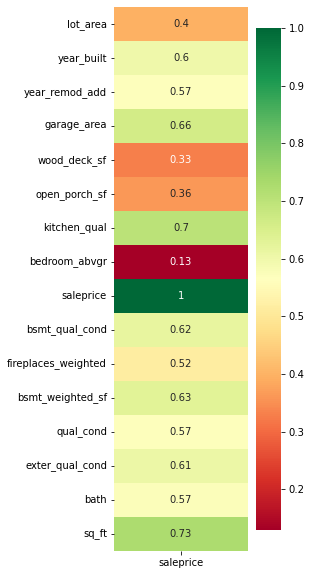

In [58]:
plt.figure(figsize = (3,10))
sns.heatmap(house.corr()[['saleprice']], cmap = 'RdYlGn', annot = True);

Out of the numeric features we have selected/created, three stand out as correlated to `saleprice`: `sq_ft`, `kitchen_qual`, and `garage_area`. It would be nice if we could use all of these features in our model, unfortunately, their variance inflation factors are quite large.

In [59]:
vif_df(house[['sq_ft', 'kitchen_qual', 'garage_area']])

,vif
kitchen_qual,15.746913
sq_ft,14.933578
garage_area,8.486028


In [60]:
vif_df(house[['sq_ft', 'kitchen_qual']])

,vif
sq_ft,13.41123
kitchen_qual,13.41123


In [61]:
vif_df(house[['sq_ft', 'garage_area']])

,vif
garage_area,7.227326
sq_ft,7.227326


In [62]:
vif_df(house[['kitchen_qual', 'garage_area']])

,vif
kitchen_qual,7.620952
garage_area,7.620952


Because each possible pair of the three features produce large VIF scores, we can only use one of these features. Let us use `sq_ft` since it has the highest correlation with `saleprice`.

In [63]:
numeric_cols = house.select_dtypes(include = 'number').columns

In [64]:
for col in numeric_cols:
    if col not in ['sq_ft', 'kitche_qual', 'garage_area']:
        print(vif_df(house[['sq_ft', col]]))

               vif
sq_ft     7.699412
lot_area  7.699412
                  vif
sq_ft       11.380339
year_built  11.380339
                      vif
sq_ft           11.323346
year_remod_add  11.323346
                 vif
sq_ft         1.6834
wood_deck_sf  1.6834
                    vif
sq_ft          1.723933
open_porch_sf  1.723933
                   vif
sq_ft         13.41123
kitchen_qual  13.41123
                     vif
sq_ft          12.668996
bedroom_abvgr  12.668996
                 vif
sq_ft      14.210332
saleprice  14.210332
                     vif
sq_ft           9.442448
bsmt_qual_cond  9.442448
                          vif
fireplaces_weighted  2.193622
sq_ft                2.193622
                       vif
sq_ft             4.870735
bsmt_weighted_sf  4.870735
                 vif
sq_ft      10.518976
qual_cond  10.518976
                       vif
sq_ft            11.739249
exter_qual_cond  11.739249
             vif
sq_ft  17.198704
bath   17.198704


The only features which produce VIFs below 5 when paired with `sq_ft` are:
- `wood_deck_sf`
- `open_porch_sf`
- `fireplaces_weighted`
- `bsmt_weighted_sf`

Although wood decks and open porches surely add value to properties, I highly doubt they are the strongest indicators for home price. Moreover, many homes simply do not have these (47.5% own a wood deck and 55.3% own an open porch). **These may be worth including in a Lasso or Ridge regression**.

In [65]:
print( (house['wood_deck_sf'] != 0).sum()/len(house) )
print( (house['open_porch_sf'] != 0).sum()/len(house) )

0.474025974025974
0.5529470529470529


Of the two left, `bsmt_weighted_sf` has a stronger correlation to `saleprice`. It produces a little higher VIF than I would like to have since I am still looking to add more columns, but our primary goal is prediction instead of inference, so slightly high VIF is not too problematic.

In [66]:
# may even be worth including all 3
vif_df(house[['sq_ft', 'bsmt_weighted_sf', 'fireplaces_weighted']])

,vif
sq_ft,5.522034
bsmt_weighted_sf,4.982449
fireplaces_weighted,2.243934


In [67]:
numeric_features = ['sq_ft', 'bsmt_weighted_sf']

In [68]:
### revise below

In [69]:
# seems early to define x

# learned about method from https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas
#X = house.select_dtypes(include = ['int64', 'float64']).copy()
#y = house['saleprice']

In [70]:
#X.drop(columns = ['kitchen_qual', 'garage_area', 'saleprice'], inplace = True)

In [71]:
#gr_liv_area,
# lot_area, bsmt_weighted_sf
#vif_df(X[['gr_liv_area', 'lot_area']])

---

## Determining Which Categorical Features to Use

In [72]:
categoric = house.select_dtypes(include = ['object'])

In [73]:
categoric

,ms_zoning,land_contour,land_slope,neighborhood,condition_1,bldg_type,house_style,mas_vnr_type,sale_type
0,RL,Lvl,Gtl,Sawyer,RRAe,1Fam,2Story,BrkFace,WD
1,RL,Lvl,Gtl,SawyerW,Norm,1Fam,2Story,BrkFace,WD
2,RL,Lvl,Gtl,NAmes,Norm,1Fam,1Story,None,WD
3,RL,Lvl,Gtl,Timber,Norm,1Fam,2Story,None,WD
4,RL,Lvl,Gtl,SawyerW,Norm,1Fam,1.5Fin,None,WD
...,...,...,...,...,...,...,...,...,...
2046,RL,HLS,Gtl,Timber,Norm,1Fam,1Story,None,WD
2047,RL,Lvl,Gtl,Edwards,Norm,1Fam,1Story,None,WD
2048,RL,Bnk,Gtl,Crawfor,Norm,1Fam,1.5Fin,None,WD
2049,RL,Lvl,Gtl,NAmes,Norm,1Fam,1Story,None,WD


In [74]:
for col in categoric.columns:
    print(categoric[col].value_counts(dropna = False))

RL         1556
RM          312
FV          101
C (all)      17
RH           14
A (agr)       1
I (all)       1
Name: ms_zoning, dtype: int64
Lvl    1815
HLS      81
Bnk      75
Low      31
Name: land_contour, dtype: int64
Gtl    1919
Mod      78
Sev       5
Name: land_slope, dtype: int64
NAmes      307
CollgCr    180
OldTown    159
Edwards    139
Somerst    130
NridgHt    118
Gilbert    113
Sawyer     109
NWAmes      87
SawyerW     86
BrkSide     76
Mitchel     75
Crawfor     69
IDOTRR      67
NoRidge     46
Timber      46
StoneBr     34
SWISU       32
MeadowV     24
Blmngtn     22
ClearCr     20
BrDale      19
NPkVill     17
Veenker     15
Blueste      6
Greens       3
GrnHill      2
Landmrk      1
Name: neighborhood, dtype: int64
Norm      1727
Feedr      106
Artery      67
RRAn        35
PosN        26
RRAe        21
PosA        11
RRNn         6
RRNe         3
Name: condition_1, dtype: int64
1Fam      1655
TwnhsE     161
Duplex      74
Twnhs       69
2fmCon      43
Name: bldg_type

We saw earlier that despite wanting to include many numeric columns, most of them were correlated to one another and we could really only use two. In the same spirit avoiding multicollinearity among the nurmic variables, let us be picky about which categorical features we decide to use in our model.

`neighborhood` immediately stands out as an indicator of property value. Almost all the other categorical variables have more than 1500 appearances of a single category (out of 2051). This leads me to believe these features will not do a great job at separating out the values of the different homes. Besides `neighborhood`, only `house_style` and `mas_vnr_type` have more spread out values. Since `mas_vnr_type` does not stand out to me as influencing the value of a home that much, I will only use `neighborhood` and `house_style` for the categorical features in our model.

\* In a future model, I will include `mas_vnr_type` to see if my intuition was correct.\*

In [75]:
categ_features = ['neighborhood', 'house_style']

---

## Making Sure Dummy Columns Agree Between Train and Test

In [77]:
house_predictors = house[numeric_features + categ_features]

In [78]:
raw_house_test = pd.read_csv('../datasets/test.csv')

In [79]:
# index [:-1] to exclude saleprice from features
# since it doesn't appear in test data
house_test = raw_house_test[init_features[:-1]].copy()

house_test.isnull().sum()

MS Zoning           0
Lot Area            0
Land Contour        0
Land Slope          0
Neighborhood        0
Condition 1         0
Bldg Type           0
House Style         0
Overall Qual        0
Overall Cond        0
Year Built          0
Year Remod/Add      0
Mas Vnr Type        1
Exter Qual          0
Exter Cond          0
Bsmt Qual          25
Bsmt Cond          25
Garage Area         0
Wood Deck SF        0
Open Porch SF       0
Kitchen Qual        0
Bedroom AbvGr       0
Full Bath           0
Half Bath           0
Fireplaces          0
Fireplace Qu      422
BsmtFin SF 1        0
Bsmt Unf SF         0
1st Flr SF          0
2nd Flr SF          0
Sale Type           0
dtype: int64

Since the columns we chose for our model do not overlap with the columns containing missing data, we do not need to fill in these missing values. All that we need to do is make sure the column names are in the same format as our train data and that we **feature engineer `bsmt_weighted_sf` into the test dataset**.

In [80]:
house_test.columns = [col.lower().replace(' ','_').replace('/','_') for col in house_test.columns]

In [81]:
# adds square feet (SF) measurements with weights:
# 1*(Finished SF) + 0.5(Unfinished SF)
house_test['bsmt_weighted_sf'] = house_test['bsmtfin_sf_1'] + 0.5*house_test['bsmt_unf_sf']
house_test.drop(columns = ['bsmtfin_sf_1', 'bsmt_unf_sf'], inplace = True)

In [82]:
house_test['sq_ft'] = house_test['1st_flr_sf'] + house_test['2nd_flr_sf']
house_test.drop(columns = ['1st_flr_sf', '2nd_flr_sf'], inplace = True)

In [83]:
house_test = house_test[numeric_features + categ_features]

In [84]:
# Train and test may have different appearance of categorical values
# dummy columns might not agree and will interfere with running model
# on test data

# dummify
train_with_dummies = pd.get_dummies(house_predictors, columns = categ_features, drop_first = True)
test_with_dummies = pd.get_dummies(house_test, columns = categ_features, drop_first = True)

In [85]:
# check column counts pre changes
print(train_with_dummies.shape)
print(test_with_dummies.shape)

(2002, 36)
(878, 34)


In [86]:
# save dummy column names from both train and test to a set
both_columns_set = set(train_with_dummies.columns).union(set(test_with_dummies.columns))

# for any column names not in set add column with 0s
for col in both_columns_set:
    if col not in train_with_dummies.columns:
        train_with_dummies[col] = 0
    if col not in test_with_dummies.columns:
        test_with_dummies[col] = 0

# arrange columns so they agree

In [87]:
# check column counts pre changes
print(train_with_dummies.shape)
print(test_with_dummies.shape)

(2002, 36)
(878, 36)


In [88]:
train_with_dummies.sum()

sq_ft                   2952734.0
bsmt_weighted_sf        1431221.5
neighborhood_Blueste          6.0
neighborhood_BrDale          19.0
neighborhood_BrkSide         76.0
neighborhood_ClearCr         20.0
neighborhood_CollgCr        180.0
neighborhood_Crawfor         69.0
neighborhood_Edwards        139.0
neighborhood_Gilbert        113.0
neighborhood_Greens           3.0
neighborhood_GrnHill          2.0
neighborhood_IDOTRR          67.0
neighborhood_Landmrk          1.0
neighborhood_MeadowV         24.0
neighborhood_Mitchel         75.0
neighborhood_NAmes          307.0
neighborhood_NPkVill         17.0
neighborhood_NWAmes          87.0
neighborhood_NoRidge         46.0
neighborhood_NridgHt        118.0
neighborhood_OldTown        159.0
neighborhood_SWISU           32.0
neighborhood_Sawyer         109.0
neighborhood_SawyerW         86.0
neighborhood_Somerst        130.0
neighborhood_StoneBr         34.0
neighborhood_Timber          46.0
neighborhood_Veenker         15.0
house_style_1.

In [89]:
test_with_dummies.sum()

sq_ft                   1311895.0
bsmt_weighted_sf         624165.5
neighborhood_Blueste          4.0
neighborhood_BrDale          11.0
neighborhood_BrkSide         32.0
neighborhood_ClearCr         17.0
neighborhood_CollgCr         87.0
neighborhood_Crawfor         32.0
neighborhood_Edwards         50.0
neighborhood_Gilbert         49.0
neighborhood_Greens           5.0
neighborhood_IDOTRR          24.0
neighborhood_MeadowV         13.0
neighborhood_Mitchel         32.0
neighborhood_NAmes          133.0
neighborhood_NPkVill          6.0
neighborhood_NWAmes          44.0
neighborhood_NoRidge         23.0
neighborhood_NridgHt         44.0
neighborhood_OldTown         76.0
neighborhood_SWISU           16.0
neighborhood_Sawyer          40.0
neighborhood_SawyerW         38.0
neighborhood_Somerst         52.0
neighborhood_StoneBr         13.0
neighborhood_Timber          24.0
neighborhood_Veenker          7.0
house_style_1.5Unf            7.0
house_style_1Story          422.0
house_style_2.

It appears that our code above did not change any of the data and only added two columns full of zeros to the test data. Success!

Lastly, we will want to arrange our columns so that the model we will eventually build takes the linear combination of the variables in the appropriate order for both the train and test data sets.

In [90]:
column_order = train_with_dummies.columns
test_with_dummies = test_with_dummies[column_order]

As a sanity check, we see if the two columns are identical term-by-term.

In [91]:
train_with_dummies.columns == test_with_dummies.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [92]:
# maybe rearrange/edit check

---

## Train-Test-Split and Building the Linear Regression

Before we try to create models to predict the saleprice we should have some idea of a baseline score. For linear regressions, the baseline score is the mean.

In [93]:
y = house['saleprice']

In [94]:
# creates an array with shape of y and filled with the mean
baseline_model = np.full_like(y, y.mean())

In [95]:
print(metrics.r2_score(baseline_model, y))
print(metrics.mean_squared_error(baseline_model, y,))
print(metrics.mean_squared_error(baseline_model, y, squared = False))

0.0
5583924624.956044
74725.66242567572


An R squared score of 0 is to be expected because by definition, R squared scores compare a model's performance against the mean. Our main metric for this project is Root Mean Squared Error (RMSE), which for the baseline model is 74,725. This means that if create a model whose RMSE score is lower, it would have been better to just guess the saleprice using the mean of the sale prices we already know.

In [96]:
X = train_with_dummies
y = house['saleprice']

In [97]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 6)

In [99]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

In [100]:
lr = LinearRegression()

In [102]:
lr.fit(X_train_sc, y_train)

LinearRegression()

In [103]:
lr.score(X_train_sc, y_train)

0.8305166248932667

In [104]:
lr.score(X_val_sc, y_val)

0.8234789724626479

In [105]:
y_pred = lr.predict(X_val_sc)
metrics.mean_squared_error(y_val, y_pred)

951242461.293546

In [106]:
metrics.mean_squared_error(y_val, y_pred, squared = False)

30842.218812749936

In [123]:
#cross val score
cross_val_score(lr, X_train_sc, y_train).mean()

0.8045549832607662

In [108]:
# test_with_dummies was test data modified so model could be applied
# renaming for readability
X_test = test_with_dummies
X_test_sc = ss.transform(X_test)

In [109]:
kag_preds = lr.predict(X_test_sc)

After running the model on the test data and submitting it to Kaggle, the RMSE came out to be 35,257.3 which is significantly higher than RMSE we obtained from our validation set. This suggests that the model is overfit/has high variance.

---

## Take Two (Really Three...) - More Features

Although it is not illustrated above, the linear model I created was my second attempt. In my first attempt, I used the features `sq_ft`, `lot_area`, `neighborhood`, and `house_style` because `lot_area` had a low VIF score when paired with `sq_ft`. I ran into an issue where roughly 1/3 of the time my R squared scores were abyssmal, leading me to believe I had some outliers in the dataset still. I went back and removed some outliers which led to `lot_area` having larger VIF score this time and in the iteration above I included `bsmt_weighted_sf` instead of `lot_area`. This gave me an improvement from an initial RMSE score of 38,000.

Earlier we made a few decisions with a goal of keeping VIF scores low. Let us build another model where we are a bit more lax with this constraint.

In [111]:
vif_df(house[['sq_ft', 'garage_area', 'wood_deck_sf', 'open_porch_sf', 'fireplaces_weighted']])

,vif
sq_ft,8.800787
garage_area,7.374722
fireplaces_weighted,2.235950
open_porch_sf,1.741490
wood_deck_sf,1.736595


The VIFs are not great and I do not feel strongly that fireplaces, open porches, and wood decks significantly influence the sales price. I expect the model I build with these variables to be overfit. This will just serve as an experiment to learn from.

In [112]:
numeric_features = ['sq_ft', 'garage_area', 'wood_deck_sf', 'open_porch_sf', 'fireplaces_weighted']

I will use the same categoric features as before.

In [113]:
categoric_features = ['neighborhood', 'house_style']

In [114]:
house_test = setup_test()

In [115]:
house

,ms_zoning,lot_area,land_contour,land_slope,neighborhood,condition_1,bldg_type,house_style,year_built,year_remod_add,...,bedroom_abvgr,sale_type,saleprice,bsmt_qual_cond,fireplaces_weighted,bsmt_weighted_sf,qual_cond,exter_qual_cond,bath,sq_ft
0,RL,13517,Lvl,Gtl,Sawyer,RRAe,1Fam,2Story,1976,2005,...,3,WD,130500,9,0,629.0,48,12,2.5,1479
1,RL,11492,Lvl,Gtl,SawyerW,Norm,1Fam,2Story,1996,1997,...,4,WD,220000,12,3,775.0,35,12,2.5,2122
2,RL,7922,Lvl,Gtl,NAmes,Norm,1Fam,1Story,1953,2007,...,3,WD,109000,9,0,894.0,35,12,1.0,1057
3,RL,9802,Lvl,Gtl,Timber,Norm,1Fam,2Story,2006,2007,...,3,WD,174000,12,0,192.0,25,9,2.5,1444
4,RL,14235,Lvl,Gtl,SawyerW,Norm,1Fam,1.5Fin,1900,1993,...,3,WD,138500,8,0,338.0,48,9,2.0,1445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,RL,11449,HLS,Gtl,Timber,Norm,1Fam,1Story,2007,2007,...,3,WD,298751,12,4,1447.5,40,12,2.0,1728
2047,RL,12342,Lvl,Gtl,Edwards,Norm,1Fam,1Story,1940,1950,...,1,WD,82500,9,0,561.5,20,9,1.0,861
2048,RL,7558,Bnk,Gtl,Crawfor,Norm,1Fam,1.5Fin,1928,1950,...,3,WD,177000,9,3,448.0,36,9,1.5,1913
2049,RL,10400,Lvl,Gtl,NAmes,Norm,1Fam,1Story,1956,1956,...,3,WD,144000,9,8,302.5,20,9,1.0,1200


In [116]:
dummy_train, dummy_test = dummify_train_test(house, numeric_features, categoric_features)

In [117]:
X_train, X_val, y_train, y_val = train_test_split(dummy_train, house['saleprice'], test_size = 0.3, random_state = 6)

In [118]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

In [119]:
lr = LinearRegression()

lr.fit(X_train_sc, y_train)
y_pred = lr.predict(X_train_sc)
y_val_pred = lr.predict(X_val_sc)

In [120]:
print(lr.score(X_train_sc, y_train))
print(lr.score(X_val_sc, y_val))
print(metrics.mean_squared_error(y_train, y_pred))
print(metrics.mean_squared_error(y_train, y_pred, squared = False))
print(metrics.mean_squared_error(y_val, y_val_pred))
print(metrics.mean_squared_error(y_val, y_val_pred, squared = False))

0.8256928531922241
0.8200877456847311
987832897.8973339
31429.80906555644
969517218.4260786
31137.071449095507


In [122]:
cross_val_score(lr, X_train_sc, y_train).mean()

0.8045549832607662

We see above that the Root Mean Squared Errors do not appear to be better than our previous model despite including more features. Unfortunately, our validation score did not make clear that our previous model was overfit. This model could very well be overfit, too. Or this model could be better and the agreement between the train and validation scores could be more authentic now that we have included more features.

One thing to note is that we would expect our R squared scores to improve from adding features. Since our R squared score did not increase, it could mean two things:
1. The previous R squared score was inflated and the new features are producing a more authentically higher R squared score,
2. or the new features contribute negligible guidance for predicting the sale price of homes. This is probably more likely.

Regardless, we should still search for a more convincingly successful model.

---

## Take Three - Kitchen Quality

In our first approach, we converted the kitchen quality ratings from descriptive ratings to numeric ratings. This could be problematic because a numbered rating system introduces an implicit relationships between the ratings that did not exist before. For example, a house may have a kitchen quality of 4 while another has a kitchen quality of 2. This does not necessarily mean the first home's kitchen is twice as nice as the second.

Let us plan to one-hot-encode `kitchen_qual`. As for numeric columns, we will use `sq_ft` again with `bsmt_weighted_sf` as these seem to be the most relevant columns that still produce low VIFs.

In [173]:
#
# Edit above: include plan to overfit a bit
# test the model
#
# include ridge
#

In [124]:
numeric_features = ['sq_ft', 'garage_area', 'bsmt_weighted_sf']
categ_features = ['neighborhood', 'house_style', 'kitchen_qual']

In [125]:
dummy_train, dummy_test = dummify_train_test(house, numeric_features, categ_features)

In [126]:
y = house['saleprice']

In [127]:
X_train, X_val, y_train, y_val = train_test_split(dummy_train, y, test_size = 0.3, random_state = 6)

In [128]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

In [129]:
lr = LinearRegression()

lr.fit(X_train_sc, y_train)
yt_pred = lr.predict(X_train_sc)
yv_pred = lr.predict(X_val_sc)

In [130]:
print(lr.score(X_train_sc, y_train))
print(lr.score(X_val_sc, y_val))
print(metrics.mean_squared_error(y_train, yt_pred))
print(metrics.mean_squared_error(y_train, yt_pred, squared = False))
print(metrics.mean_squared_error(y_val, yv_pred))
print(metrics.mean_squared_error(y_val, yv_pred, squared = False))

0.8759465544939518
0.8666992405886502
703035284.6262172
26514.812551217805
718335624.0543063
26801.783971487912


In [131]:
cross_val_score(lr, X_train_sc, y_train).mean()

0.8626531975648142

It is not clear to me why these warnings appear, but they do not seem to harm the code's ability to produce metrics on our regression. The R squared scores of our model are extremely poor but the RMSE scores are a bit better. 

In [234]:
#
# Edit above line, fixed:
# issue was running scores on unscaled datasets when fit was scaled
#
# 

In [235]:
# Now I am curious what will happen to my model's performance if I am a little more lax on my choice of features. Earlier we made decisions to leave out some features because they contributed to large VIFs (`garage_area`) or they seemed like they only applied to a significantly smaller subset of the data (``)

---

## Ridge

In [132]:
alphas = np.logspace(0, 5, 100)

ridge_cv = RidgeCV(alphas = alphas, cv = 5)

In [133]:
# using the same train test split as above
# X_train and X_val have already been 'standard scaled'
# expressed as X_train_sc and X_val_sc

ridge_cv.fit(X_train_sc, y_train);

In [134]:
ridge_cv.alpha_

1.0

In [135]:
alphas = np.logspace(-10, 1, 100)

ridge_cv = RidgeCV(alphas = alphas, cv = 5)

In [136]:
# using the same train test split as above
# X_train and X_val have already been 'standard scaled'
# expressed as X_train_sc and X_val_sc

ridge_cv.fit(X_train_sc, y_train);

In [137]:
ridge_cv.alpha_

1e-10

In both instances of running `RidgeCV`, the optimal alpha value is the lowest. This means that Ridge views our model as a good fit already and believes the penalty term is not very necessary. For the sake of example, let us fit a Ridge regression with the default alpha = 1 that our first RidgeCV suggested.

In [138]:
ridge = Ridge()

In [140]:
ridge.fit(X_train_sc, y_train);

In [142]:
yt_pred = ridge.predict(X_train_sc)
yv_pred = ridge.predict(X_val_sc)

In [143]:
print(ridge.score(X_train_sc, y_train))
print(ridge.score(X_val_sc, y_val))
print(metrics.mean_squared_error(y_train, yt_pred))
print(metrics.mean_squared_error(y_train, yt_pred, squared = False))
print(metrics.mean_squared_error(y_val, yv_pred))
print(metrics.mean_squared_error(y_val, yv_pred, squared = False))

0.8759446677927176
0.8667628148927261
703045976.9333413
26515.01417939167
717993032.7022852
26795.39200501245


In [141]:
cross_val_score(ridge, X_train_sc, y_train).mean()

0.8631841956284261

---

## Take Four - Lot Area and Quality/Condition

We will eventually use Ridge and Lasso to deal with overfit models. First, let us include a few more variables that may make our model overfit. Namely, let us include `lot_area` and `qual_cond`.

In [285]:
numeric_features = ['sq_ft', 'garage_area', 'bsmt_weighted_sf', 'lot_area', 'qual_cond']
categ_features = ['neighborhood', 'house_style', 'kitchen_qual']

In [286]:
dummy_train, dummy_test = dummify_train_test(house, numeric_features, categ_features)

In [287]:
X_train, X_val, y_train, y_val = train_test_split(dummy_train, y, test_size = 0.3, random_state = 8)

In [288]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

In [289]:
lr = LinearRegression()

lr.fit(X_train_sc, y_train)
yt_pred = lr.predict(X_train_sc)
yv_pred = lr.predict(X_val_sc)

In [290]:
print(lr.score(X_train_sc, y_train))
print(lr.score(X_val_sc, y_val))
print(metrics.mean_squared_error(y_train, yt_pred))
print(metrics.mean_squared_error(y_train, yt_pred, squared = False))
print(metrics.mean_squared_error(y_val, yv_pred))
print(metrics.mean_squared_error(y_val, yv_pred, squared = False))

0.8947403220017641
0.9018904981266351
585153630.4006903
24189.94895407368
553068947.5777028
23517.417961538693


In [291]:
X_test_sc = ss.transform(dummy_test)

In [292]:
kag_preds = lr.predict(X_test_sc)

Our scores once again improve, though not very significantly. Feeling more confident that our model is overfit, let us now use Ridge and Lasso.

In [293]:
submit(raw_house_test, kag_preds, 5)

The Kaggle submission score was 30,007, which again is significantly lower than the scores anticipate.

--- 

## Take Five - Even More Features

In [294]:
house.select_dtypes('number').columns

Index(['lot_area', 'year_built', 'year_remod_add', 'garage_area',
       'wood_deck_sf', 'open_porch_sf', 'kitchen_qual', 'bedroom_abvgr',
       'saleprice', 'bsmt_qual_cond', 'fireplaces_weighted',
       'bsmt_weighted_sf', 'qual_cond', 'exter_qual_cond', 'bath', 'sq_ft'],
      dtype='object')

In [295]:
house.select_dtypes('object').columns

Index(['ms_zoning', 'land_contour', 'land_slope', 'neighborhood',
       'condition_1', 'bldg_type', 'house_style', 'mas_vnr_type', 'sale_type'],
      dtype='object')

In [296]:
numeric_features = ['sq_ft', 'bedroom_abvgr', 'garage_area', 'bsmt_weighted_sf', 'lot_area', 'year_built', 'bath', 'qual_cond', 'fireplaces_weighted']
categ_features = ['neighborhood', 'house_style', 'kitchen_qual']

In [297]:
dummy_train, dummy_test = dummify_train_test(house, numeric_features, categ_features)

In [298]:
X_train, X_val, y_train, y_val = train_test_split(dummy_train, y, test_size = 0.2, random_state = 8)

In [299]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

In [300]:
lr = LinearRegression()

lr.fit(X_train_sc, y_train)
yt_pred = lr.predict(X_train_sc)
yv_pred = lr.predict(X_val_sc)

In [301]:
print(lr.score(X_train_sc, y_train))
print(lr.score(X_val_sc, y_val))
print(metrics.mean_squared_error(y_train, yt_pred))
print(metrics.mean_squared_error(y_train, yt_pred, squared = False))
print(metrics.mean_squared_error(y_val, yv_pred))
print(metrics.mean_squared_error(y_val, yv_pred, squared = False))

0.9075228715252514
0.9100119238912097
509583060.948662
22573.946508057958
528836763.0327791
22996.451096479628


In [302]:
X_test_sc = ss.transform(dummy_test)

In [303]:
kag_preds = lr.predict(X_test_sc)

In [304]:
submit(raw_house_test, kag_preds, 6)

---

## Lasso

In [305]:
alphas = np.logspace(0, 5, 100)

lasso_cv = LassoCV(alphas = alphas, cv = 5)

In [306]:
lasso_cv.fit(X_train_sc, y_train);

In [307]:
lasso_cv.alpha_

298.364724028334

In [314]:
alphas = np.logspace(-10, 1, 100)

lasso_cv =LassoCV(alphas = alphas, cv = 5)

In [315]:
lasso_cv.fit(X_train_sc, y_train);

In [316]:
lasso_cv.alpha_

10.0

We see above that our Lasso model was best fit with alpha = 298.

In [317]:
lasso = Lasso(alpha = 298.36)

In [318]:
lasso.fit(X_train_sc, y_train);

In [322]:
yt_pred = lasso.predict(X_train_sc)
yv_pred = lasso.predict(X_val_sc)

In [323]:
print(lasso.score(X_train_sc, y_train))
print(lasso.score(X_val_sc, y_val))
print(metrics.mean_squared_error(y_train, yt_pred))
print(metrics.mean_squared_error(y_train, yt_pred, squared = False))
print(metrics.mean_squared_error(y_val, yv_pred))
print(metrics.mean_squared_error(y_val, yv_pred, squared = False))

0.9067927186731571
0.9105503346489553
513606472.2663283
22662.887553582583
525672661.5804485
22927.552455080076


In [324]:
lasso_kag_preds = lasso.predict(X_test_sc)

In [325]:
submit(raw_house_test, lasso_kag_preds, 7)

Kaggle score: 27,992.

---

## Residuals

---

## Exploring Why the Validation Score is So Low 1/3 of The Time

In [114]:
kag_preds

array([163579.64309522, 222738.74732565, 181249.06768879,  97206.7680454 ,
       171265.59670832,  87365.33954503, 104056.70756845, 183462.48781632,
       210778.99809075, 159366.73001299, 165541.88763481, 104730.580277  ,
       151160.6010684 , 292402.29006131, 167802.33391479, 102105.466006  ,
       134509.81370155, 120226.65244206, 207353.87190157, 152352.93701053,
       111387.49396107, 123743.272013  , 180135.40792217, 161663.35359981,
       157508.84200723, 145805.10902674, 146366.39871188, 138453.1293064 ,
       147057.4568179 ,  63794.73543714, 105363.75973876,  72580.82920917,
       225550.95555952, 169278.23321377, 202455.04011885, 160716.3918256 ,
       150486.63075016,  89568.67717507,  77941.4245881 , 210298.37741024,
       168539.03518039, 203525.09849483, 150374.50410435, 153474.98426336,
       237967.02390511,  98410.15480745, 212142.51177239, 145126.92217398,
       104536.54372562, 147425.40887368, 112878.52456151, 170360.58113446,
       214946.77880131, 1

---

## Running Our Model on the Test CSV File!

In [792]:
kag_sub = {'Id': raw_house_test['Id'], 'SalePrice': kag_preds}
kag_sub = pd.DataFrame(kag_sub)
kag_sub.to_csv('../datasets/submission3_john.csv', index = False)

In [793]:
kag_sub.to_csv('../datasets/submission3_john.csv', index = False)

In [ ]:
# create some variable with scores and submission results - notes on what you did
# to keep track of what you did and how it performed

## To Check On Other Attempts

try models without scaling

Check msn_vnr_type to see if intuition was correct.

Try kitchen rating with 0-5 values even with correlation

need to use ridge/lasso - for overfit data. try with slightly more numeric columns than you'd want
- overfit with open porch sf, wood_deck_sf, and possibly bsmt_sf

try including some features despite high vif
- prediction not inference

check line assumptions/residuals